In [144]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import missingno as msno
import plotly.express as px # plotting geo data
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from Own_imputers import PriorityGroupImputer

# Train

## Data

In [ ]:
data = pd.read_csv("train.csv", header=0)
data = data.drop(columns=['is_promoted','sticker','price_drop_date'])

train, test = train_test_split(data.sort_values('added_time'),test_size=0.2, shuffle=False)

In [139]:
type_map = {
    'energy_label': 'category',
    'postcode': 'category',
    'advertiser' : 'category',
    'province' : 'category', 
    'house_type' : 'category',
    'subtype' : 'category',
    'new_building': 'bool'
}

house_map = {
    'Apartments & Flats': [
        'Appartement', 'Gelijkvloers app.', 'Duplex', 'Triplex', 'Dakappartement',
        'Penthouse', 'Serviceflat', 'Assistentie-appartement', 'Studio', 'Studio met slaaphoek', 
        'App. vrij beroep', 'Appartementsgebouw'
    ],
    'Single-Family Houses': [
        'Eengezinswoning', 'Woning', 'Villa', 'Villa-landhuis', 'Moderne villa',
        'Cottage', 'Bungalow', 'Koppelwoning', 'Koppelvilla', 'Hoekwoning', 'Rijwoning', 'Bel-étage', 'Burgerswoning'
    ],
    'Historical & Luxurious Homes': [
        'Herenhuis', 'Herenwoning', 'Uitzonderlijke woning', 'Kasteel', 'Pastorijwoning'
    ],
    'Farm & Rural Houses': [
        'Hoeve', 'Boerderij', 'Fermette', 'Chalet'
    ],
    'Mixed-Use & Unique Properties': [
        'Gemengd gebruik', 'Arbeiderswoning', 'Kangoeroewoning', 'Woonboot', 'Loft',
        'Split-level', 'Patio woning', 'Buitenverblijf', 'Vakantiewoning'
    ]
}

# Function to categorize houses
def categorize_house(house_type):
    for category, types in house_map.items():
        if house_type in types:
            return category
    return 'Other'

postcode_list = pd.read_csv("BE.txt", sep="\t", header=None)[[1,9,10]]
postcode_list.columns = ['postcode','lat','lon']
postcode_list['postcode']=postcode_list['postcode'].astype('category')
postcode_list = postcode_list.groupby('postcode', observed=False)[['lat','lon']].mean()

class preprocess:
    def __init__(self, postcode_source=None, type_map = {}):
        self.subtype_imputer = PriorityGroupImputer(target_cols=['subtype'], priority_groups = {1:['bedrooms_cat']}, strategy = 'mode')
        self.geo_imputer = PriorityGroupImputer(target_cols=['lat','lon'], priority_groups = {1:['postcode']}, strategy = 'external', data_source=postcode_source)
        self.clf_geo = EllipticEnvelope(contamination=0.0002, support_fraction=0.9)
        self.clf_area = EllipticEnvelope(contamination=0.0002, support_fraction=0.9)
        self.area_imputer = PriorityGroupImputer(target_cols=['area'], priority_groups = {1:['bedrooms_cat','house_type'], 2:['bedrooms_cat']}, strategy = 'median')
        self.ev_imputer_median = PriorityGroupImputer(target_cols=['energy_value'], priority_groups = {1:['energy_label','province']}, strategy = 'median', fallback=True)
        self.type_map = type_map
    
    def missing_checker(self, df):
            missing_values = round(df.isna().sum()/len(df)*100,2)
            missing_checker_df = df.isna()*1
            missing_checker_df = missing_checker_df.drop(columns=missing_values.index[missing_values==0].tolist())
            missing_checker_df = missing_checker_df.add_suffix('_miss')
            missing_checker_df = (missing_checker_df==1)
            return missing_checker_df

    def train(self, df):
        missing = self.missing_checker(df)
        
        df['bedrooms_cat'] = pd.cut(df['bedrooms'], bins=[-1,0,1,2,3,4,5,6,float('inf')], labels=['0','1','2','3','4','5','6','7+'])
        df['house_type'] = df['subtype'].apply(categorize_house)

        df = self.subtype_imputer.fit_transform(df)
        df = self.geo_imputer.fit_transform(df)

        outliers_geo = self.clf_geo.fit_predict(df[['lat','lon']])
        df['lat'] = df['lat'].where((df['lat']<52) & (df['lat']>49), np.nan)
        df['lon'] = df['lon'].where((df['lon']<8) & (df['lat']>2), np.nan)
        df = self.geo_imputer.transform(df)

        outliers_area = self.clf_area.fit_predict(df[['area']].dropna())
        df['area'] = df['area'].where(~df['id'].isin(df[['area','id']].dropna()[outliers_area==-1]['id']), np.nan)
        df = self.area_imputer.fit_transform(df)
        
        df = self.ev_imputer_median.fit_transform(df)
        
        df = pd.concat([df, missing], axis=1)
        df['advertiser'] = df['advertiser'].fillna('Other')

        df = df.astype(self.type_map)
        return df

    def test(self, df):   
        missing = self.missing_checker(df)
        
        df['bedrooms_cat'] = pd.cut(df['bedrooms'], bins=[-1,0,1,2,3,4,5,6,float('inf')], labels=['0','1','2','3','4','5','6','7+'])
        df['house_type'] = df['subtype'].apply(categorize_house)

        df = self.subtype_imputer.transform(df)
        df = self.geo_imputer.transform(df)

        outliers_geo = self.clf_geo.predict(df[['lat','lon']])
        df['lat'] = df['lat'].where((df['lat']<52) & (df['lat']>49), np.nan)
        df['lon'] = df['lon'].where((df['lon']<8) & (df['lat']>2), np.nan)
        df = self.geo_imputer.transform(df)

        outliers_area = self.clf_area.predict(df[['area']].dropna())
        df['area'] = df['area'].where(~df['id'].isin(df[['area','id']].dropna()[outliers_area==-1]['id']), np.nan)
        df = self.area_imputer.transform(df)
        
        df = self.ev_imputer_median.transform(df)
        
        df = pd.concat([df, missing], axis=1)
        df['advertiser'] = df['advertiser'].fillna('Other')

        df = df.astype(self.type_map)
        return df

In [140]:
X_train, X_val, y_train, y_val = train_test_split(train.drop(columns='price'),train['price'], shuffle=False, test_size=0.2)
prep = preprocess(postcode_source=postcode_list, type_map=type_map)
X_train = prep.train(X_train)
X_val = prep.test(X_val)

In [54]:
# fig = px.scatter_geo(train, lat='lat', lon='lon', scope='europe')
# fig.update_geos(showcountries=True, showcoastlines=True)
# fig.show()

In [58]:
# ev_imputer = KNNImputer(n_neighbors=10, weights='distance')
# imputed_data = ev_imputer.fit_transform(train[['energy_value','area','is_appartment','new_building', 'lat','lon']])
# # df_imputed = pd.DataFrame(imputed_data)
# train['energy_value']= pd.DataFrame(imputed_data)[0]

In [59]:
# plt.scatter(x=train['energy_value'],y=train['area'],c=missing_checker['energy_value'])
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim()

## Feature engineering

In [143]:
features = (['house_type',
             'bedrooms', 'area',
             'new_building', 'lat', 'lon', 'foto_amount',
             'energy_value', 
             'area_miss',  'energy_value_miss',
             'Cluster'])
# 'province', advertiser','advertiser_miss', 'lat_miss',  'subtype_miss', 'is_appartment', 

In [86]:
X_train.shape

(17324, 24)

In [124]:
def cluster_labels(df, features, n_clusters=300):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)
    X_new = pd.DataFrame()
    X_new["Cluster"] = kmeans.fit_predict(X_scaled)
    return X_new

In [147]:
cluster_pred = KNeighborsClassifier(n_neighbors=5, weights='distance')
cluster_pred.fit(X_train[['lat','lon']],X_train['Cluster'])
X_val['Cluster']= cluster_pred.predict(X_val[['lat','lon']])

In [141]:
X_train = X_train.reset_index(drop=True).join(cluster_labels(X_train, ['lat','lon']))

## Dimensionality Reduction

## Model

### KNN

In [66]:
# X_train, y_train = train[['is_appartment','area','lat','lon','foto_amount','energy_value','house_type']].copy(),train['price'].copy()

# X_train_encoded = pd.get_dummies(X_train, columns=['house_type'])

# scaler = StandardScaler()
# X_train_encoded[['area','lat','lon','energy_value','foto_amount']] = scaler.fit_transform(X_train_encoded[['area','lat','lon','energy_value','foto_amount']])

In [67]:
# scores_KNN = []
# for i in range(2,60,2):
#     neigh_model = KNeighborsRegressor(n_neighbors=i, weights='distance')
#     scores_KNN.append(cross_val_score(neigh_model, X_train_encoded, y_train, cv=5, scoring='neg_mean_absolute_percentage_error')*-1)

# scores_KNN = pd.DataFrame(scores_KNN)
# plt.scatter((scores_KNN.index+1)*2, scores_KNN.apply(np.mean, axis=1))

In [68]:
# neigh_model_final = KNeighborsRegressor(n_neighbors=14, weights='distance')
# neigh_model_final.fit(X_train_encoded,y_train)

### XGBoost

In [69]:
#X_train, X_val, y_train, y_val = train_test_split(train[features],train['price'], shuffle=False, test_size=0.2)

dtrain = xgb.DMatrix(X_train[features], label=y_train, enable_categorical=True)
dval = xgb.DMatrix(X_val[features],label=y_val, enable_categorical=True)

evallist = [(dval, 'val')]

param_xgb = {'max_depth': 6, 'eta': 0.1, 'objective': 'reg:squarederror', 'reg_lambda':10, 'reg_alpha':10,}

xgb_regressor = xgb.train(
    params=param_xgb,
    dtrain=dtrain,
    num_boost_round=500
)
xgb_regressor.eval_set([(dval,'val')])

'[0]\tval-rmse:105817.08883330690150615'

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

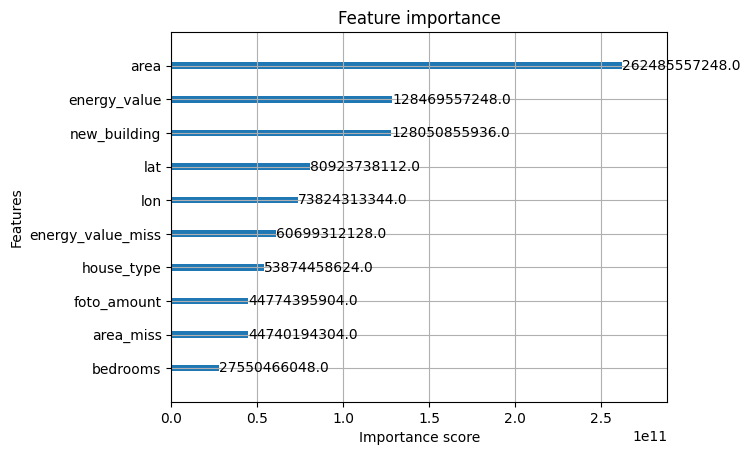

In [71]:
xgb.plot_importance(xgb_regressor, importance_type='gain')

In [74]:
X_train, y_train = train[features].copy(),train['price'].copy()
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)

param_xgb = {'max_depth': 6, 'eta': 0.1, 'objective': 'reg:squarederror', 'reg_lambda':10, 'reg_alpha':10,}

xgb_regressor_final = xgb.train(
    params=param_xgb,
    dtrain=dtrain,
    num_boost_round=500
)

# Test

## Data

In [25]:
# test = pd.read_csv("test.csv", header=0)
test = test.reset_index()
# test = test.drop(columns=['is_promoted','sticker','price_drop_date'])
test['energy_label'] = test['energy_label'].astype('category')
test['new_building'] = test['new_building'].astype('bool')
test['postcode'] = test['postcode'].astype('category')

test['bedrooms_cat'] = pd.cut(test['bedrooms'], bins=[-1,0,1,2,3,4,5,6,float('inf')], labels=['0','1','2','3','4','5','6','7+'])
test['house_type'] = test['subtype'].apply(categorize_house)

In [26]:
missing_values = round(test.isna().sum()/len(test)*100,2)
missing_checker = test.isna()*1
# missing_checker = missing_checker.drop(columns=missing_values.index[(missing_values>30) | (missing_values==0)].tolist()).drop(columns='energy_label').reset_index()
missing_checker = missing_checker.drop(columns=missing_values.index[missing_values==0].tolist()).reset_index(drop=True)

missing_checker.columns = ['area_miss', 'lat_miss', 'lon_miss', 'advertiser_miss', 'subtype_miss', 'energy_value_miss', 'energy_label_miss']
missing_checker = (missing_checker==1)
test = pd.concat([test, missing_checker], axis=1)

In [27]:
test['advertiser'] = test['advertiser'].fillna('Other')
test['advertiser'] = test['advertiser'].astype('category')

In [ ]:
test = subtype_imputer.transform(test)

test = geo_imputer.transform(test)

outliers_geo_test = clf_geo.predict(test[['lat','lon']])
test['lat'] = test['lat'].where(outliers_geo_test==1, np.nan)
test['lon'] = test['lon'].where(outliers_geo_test==1, np.nan)

test = geo_imputer.transform(test)

outliers_area = clf_area.predict(test[['area']].dropna())
test['area'] = test['area'].where(~test['id'].isin(test[['area','id']].dropna()[outliers_area==-1]['id']), np.nan)

test = area_imputer.transform(test)

test = ev_imputer_median.transform(test)
imputed_data = ev_imputer.transform(test[['energy_value','area','is_appartment','new_building', 'lat','lon']])
test['energy_value']= pd.DataFrame(imputed_data)[0]

test['house_type'] = test['house_type'].astype('category')
test['province']=test['province'].astype('category')

## KNN

In [ ]:
# X_test = test[['is_appartment','area','lat','lon','foto_amount','energy_value','house_type']].copy()

# X_test_encoded = pd.get_dummies(X_test, columns=['house_type'])

# scaler = StandardScaler()
# X_test_encoded[['area','lat','lon','energy_value','foto_amount']] = scaler.fit_transform(X_test_encoded[['area','lat','lon','energy_value','foto_amount']])
# X_test_encoded.isna().apply(sum)
# y_test = test['price'].copy()
# y_pred_test = neigh_model_final.predict(X_test_encoded)

## XGBoost

In [ ]:
X_test, y_test = test[features].copy(),test['price'].copy()
dtest = xgb.DMatrix(X_test, enable_categorical=True)

y_pred_test=xgb_regressor_final.predict(dtest)

## Error bars

In [615]:
mean_error_1=(y_pred_test/y_test-1).mean()
error_bound_1 = (y_pred_test/y_test-1).std()/len(y_pred_test)**(1/2)*1.96

mean_error_2=abs(y_pred_test/y_test-1).mean()
error_bound_2 = abs(y_pred_test/y_test-1).std()/(len(y_pred_test)**(1/2))*1.96

mean_error_3=((y_pred_test-y_test)**2).mean()**(1/2)
error_bound_3 = abs(y_pred_test-y_test).std()/(len(y_pred_test)**(1/2))*1.96

# Submission metrics

In [510]:
y_pred_final = pd.DataFrame()
y_pred_final['id']=test['id']
y_pred_final['lower']=y_pred_test*(1-mean_error_1-error_bound_1)
y_pred_final['upper']=y_pred_test*(1-mean_error_1+error_bound_1)
y_pred_final['pred']=y_pred_test*(1-mean_error_1)

y_pred_final.to_csv(f"xgb_simple_1.csv", index=False)

In [513]:
y_pred_final = pd.DataFrame()
y_pred_final['id']=test['id']
y_pred_final['lower']=y_pred_test*(1-mean_error_2-error_bound_2)
y_pred_final['upper']=y_pred_test*(1+mean_error_2+error_bound_2)
y_pred_final['pred']=y_pred_test

y_pred_final.to_csv(f"xgb_simple_2.csv", index=False)

In [512]:
y_pred_final = pd.DataFrame()
y_pred_final['id']=test['id']
y_pred_final['lower']=np.maximum(y_pred_test-mean_error_3-error_bound_3,0)
y_pred_final['upper']=y_pred_test+mean_error_3+error_bound_3
y_pred_final['pred']=y_pred_test

y_pred_final.to_csv(f"xgb_simple_3.csv", index=False)